In [50]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, \
    plot_precision_recall_curve, average_precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import sys
import warnings
from matplotlib.pyplot import figure
warnings.filterwarnings("ignore")

In [65]:
def create_lag_variables(df, lags, cols):
    df = df.assign(**{
        '{} (t-{})'.format(col, t): csv_data[col].shift(t)
        for t in lags
        for col in cols_to_lag
    })
    return df
# create_lag_variables(csv_data, lags, cols_to_lag)

def wavg(group):
    group = group.reset_index().drop(['index'], axis=1)
    i = 0
    weight_sum = 0
    for j in range(0, group.shape[0]):
        i = i + 1
        weight_sum = weight_sum + i
#         print(group.iloc[[j]] * i)
        group.iloc[[j]] = group.iloc[[j]] * i
#     print(group)
    return group.iloc[:, :].sum(axis=0) / weight_sum

def DataPreprocess(raw_data, back_rows, forward_rows, is_weighted):
    raw_data = raw_data.drop(['Dates'], axis=1)
    start_index = back_rows
    end_index = raw_data.shape[0] - forward_rows + 1
    new_rows = []
    for i in range(start_index, end_index):
        if is_weighted:
            new_rows.append(wavg(raw_data.iloc[i-back_rows:i, :]))
        else:
            new_rows.append(raw_data.iloc[i-back_rows:i, :].mean(axis=0))
    training_data = pd.concat(new_rows, axis=1).T
    HY_labels = raw_data.iloc[start_index + forward_rows - 1: raw_data.shape[0], [8]].reset_index().drop(['index'], axis=1)
    IG_labels = raw_data.iloc[start_index + forward_rows - 1: raw_data.shape[0], [13]].reset_index().drop(['index'], axis=1)
    HY_spread_labels = raw_data.iloc[start_index + forward_rows - 1: raw_data.shape[0], [12]].reset_index().drop(['index'], axis=1)
    return training_data, HY_labels, IG_labels, HY_spread_labels

def print_IG_features():
    
    features_IG = np.array(X_IG_train.columns)
    features_IG = list(features_IG)

    for item in drop_list:
        features_IG.remove(item)

    features_IG = np.array(features_IG) 
    figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
    importances = clf_IG_forrest.feature_importances_
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(features_IG)) + 0.5
    pl.barh(padding, importances[sorted_idx], align='center')
    pl.yticks(padding, features_IG[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance for CDX.IG")
    pl.show()
    

# Print IG Features
def print_HY_features():
    
    features_IG = np.array(X_IG_train.columns)
    features_IG = list(features_IG)

    for item in drop_list:
        features_IG.remove(item)

    features_IG = np.array(features_IG) 
    figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
    importances = clf_HY_forrest.feature_importances_
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(features_IG)) + 0.5
    pl.barh(padding, importances[sorted_idx], align='center')
    pl.yticks(padding, features_IG[sorted_idx])
    pl.xlabel("Relative Importance")
    pl.title("Variable Importance for CDX.HY")
    pl.show()
        

In [106]:
def total_prediction(days_ahead = [1,7,30,60,90]):
    file_path = "./Economic_data_clean_20200801.xlsx"

    csv_data = pd.read_excel(file_path)
    print("Preprocessing data...")
    csv_data['EARN_DOWN'] = csv_data['EARN_DOWN'].astype(np.float16)
    csv_data['EARN_UP'] = csv_data['EARN_DOWN'].astype(np.float16)
    csv_data['CDX_HY_momentum'] = (csv_data['CDX_HY_10D_AVG'] - csv_data['CDX_HY_30D_AVG']) / csv_data['CDX_HY_30D_AVG']
    csv_data['CDX_IG_momentum'] = (csv_data['CDX_IG_10D_AVG'] - csv_data['CDX_IG_30D_AVG']) / csv_data['CDX_IG_30D_AVG']
    csv_data['GOLD_momentum'] =  csv_data['GOLD'] .rolling(window=10).mean() -  csv_data['GOLD'] .rolling(window=30).mean() /  csv_data['GOLD'] .rolling(window=30).mean()

    final_data = csv_data.dropna().copy()
    
    model_results = {}
    for dh in days_ahead:
        print("============{} Day============".format(dh))
        model_results[dh] = {}
        HY_colname = 'CDX_HY_UpNext_{}Day'.format(dh)
        IG_colname = 'CDX_IG_UpNext_{}Day'.format(dh)
        
        csv_data[HY_colname] = csv_data['CDX_HY'].shift(-dh) > csv_data['CDX_HY']
        csv_data[IG_colname] = csv_data['CDX_IG'].shift(-dh) > csv_data['CDX_IG']

        complete_data = csv_data.dropna().copy()

        X = complete_data.drop([HY_colname, IG_colname,'Dates'],axis=1)
        feature_cols = X.columns
        
        Y_HY = complete_data[HY_colname]
        Y_IG = complete_data[HY_colname]

        # Split your data
        print("Splitting Test and Training Data...")
        X_HY_train, X_HY_test, Y_HY_train, Y_HY_test = train_test_split(X, Y_HY, test_size=.25)
        X_IG_train, X_IG_test, Y_IG_train, Y_IG_test = train_test_split(X, Y_IG, test_size=.25)


        # Encode Target
        print("Encoding target data...")
        lab_enc = preprocessing.LabelEncoder()
        Y_HY_train_encoded = lab_enc.fit_transform(Y_HY_train)
        Y_IG_train_encoded = lab_enc.fit_transform(Y_IG_train)

        print("Training the HY models (1st iteration)...")
        AB_model_HY = AdaBoostClassifier().fit(X_HY_train, Y_HY_train_encoded)
        print("Training the IG models (1st iteration)...")
        AB_model_IG = AdaBoostClassifier().fit(X_IG_train, Y_IG_train_encoded)
        
        Y_HY_test_encoded = lab_enc.fit_transform(Y_HY_test)
        Y_IG_test_encoded = lab_enc.fit_transform(Y_IG_test)

        Y_HY_pred = AB_model_HY.predict(X_HY_test)
        Y_IG_pred = AB_model_IG.predict(X_IG_test)
        
        print('1 MODEL: HY Accuracy '+str(metrics.accuracy_score(Y_HY_test_encoded, Y_HY_pred)))
        print('1 MODEL: IG Accuracy '+str(metrics.accuracy_score(Y_IG_test_encoded, Y_IG_pred)))
        
        #feature_plot
        feat_impt_HY = pd.DataFrame(AB_model_HY.feature_importances_, columns=['Feature Importance'], index=X.columns)
        feat_impt_HY = feat_impt_HY.sort_values('Feature Importance', ascending=True)
        feature_plot_HY = feat_impt_HY.plot(kind='barh', title='Feature Importance HY',figsize=(10, 12))
        feat_impt_HY = feat_impt_HY[-20:]
        
        
        feat_impt_IG = pd.DataFrame(AB_model_IG.feature_importances_, columns=['Feature Importance'], index=X.columns)
        feat_impt_IG = feat_impt_IG.sort_values('Feature Importance', ascending=True)
        feature_plot_IG = feat_impt_IG.plot(kind='barh', title='Feature Importance IG',figsize=(10, 12))
        feat_impt_IG = feat_impt_IG[-20:]

        HY_area_roc = roc_auc_score(Y_HY_test , Y_HY_pred)
        IG_area_roc = roc_auc_score(Y_IG_test , Y_IG_pred)
        
        fig1, ax = plt.subplots()
        HY_ROCplot = plot_roc_curve(AB_model_HY, X_HY_test, Y_HY_test_encoded, ax=ax)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title("HY area under ROC: {:.2%}".format(HY_area_roc))
        HY_ROCplot
        
        fig2, ax = plt.subplots()
        IG_ROCplot = plot_roc_curve(AB_model_IG, X_IG_test, Y_IG_test_encoded, ax=ax)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title("IG area under ROC: {:.2%}".format(IG_area_roc))
        IG_ROCplot

        final_data[HY_colname] = AB_model_HY.predict(final_data[feature_cols])
        final_data[IG_colname] = AB_model_IG.predict(final_data[feature_cols])
        
        model_results[dh][HY_colname] = {'ROCplot':fig1, 'area_roc':HY_area_roc, 'feature_plot':feature_plot_HY}
        model_results[dh][IG_colname] = {'ROCplot':fig2, 'area_roc':IG_area_roc, 'feature_plot':feature_plot_IG}
        
    model_results['final_result'] = final_data
    return model_results
        

Preprocessing data...
============3 Day============
Splitting Test and Training Data...
Encoding target data...
Training the HY models (1st iteration)...
Training the IG models (1st iteration)...
1 MODEL: HY Accuracy 0.6402439024390244
1 MODEL: IG Accuracy 0.6260162601626016


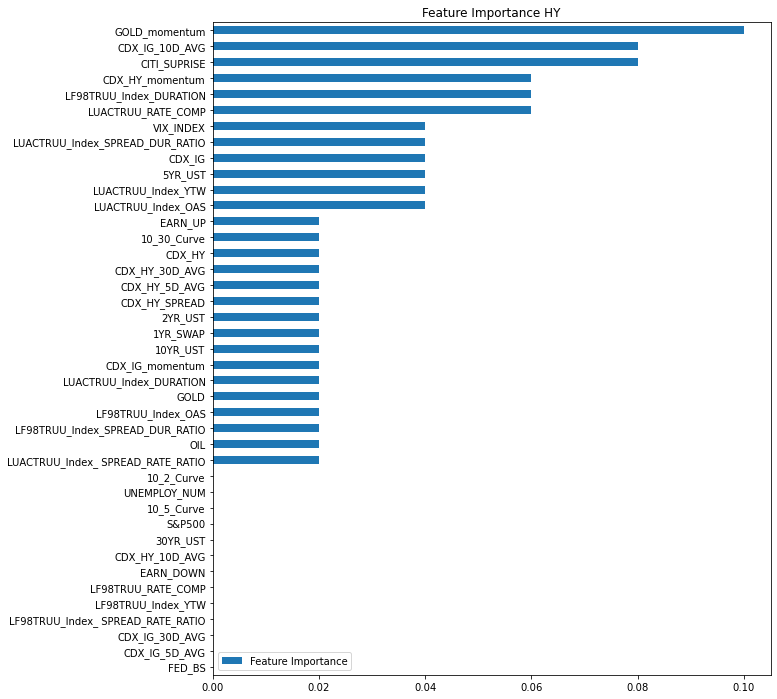

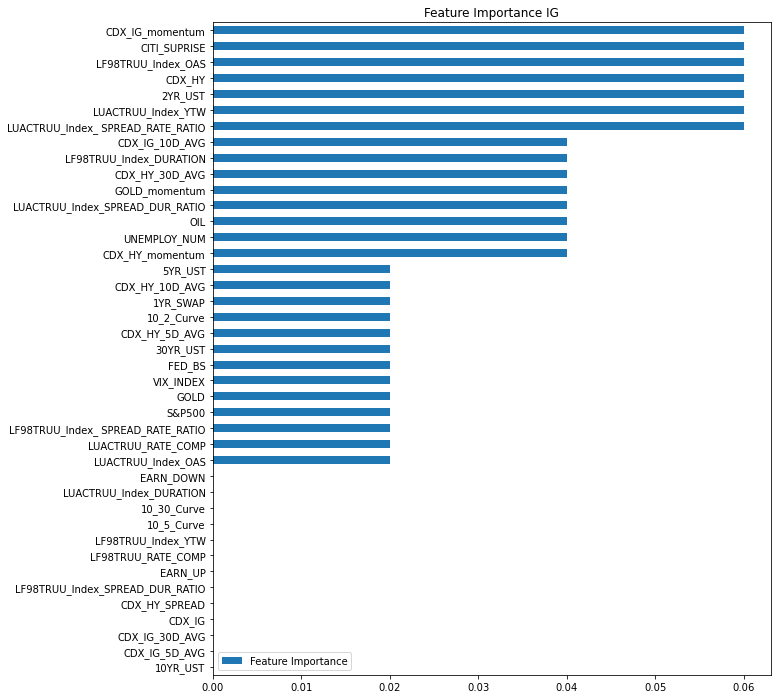

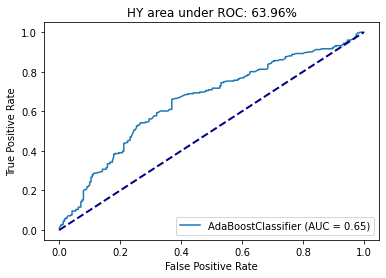

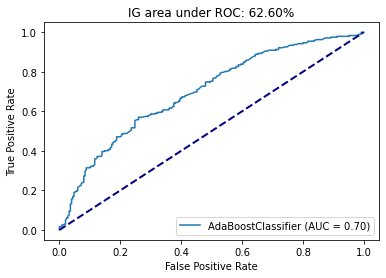

In [118]:
model_results = total_prediction([3])

In [86]:
model_results['final_result']

,Dates,10YR_UST,10_2_Curve,10_30_Curve,10_5_Curve,1YR_SWAP,2YR_UST,30YR_UST,5YR_UST,CDX_HY,...,S&P500,UNEMPLOY_NUM,VIX_INDEX,CDX_HY_momentum,CDX_IG_momentum,GOLD_momentum,CDX_HY_UpNext_1Day,CDX_IG_UpNext_1Day,CDX_HY_UpNext_7Day,CDX_IG_UpNext_7Day
29,2012-09-19,1.772,1.514,1.188,1.089,0.1390,0.258,2.960,0.683,102.126,...,1461.05,392.0,13.88,0.019667,-0.082296,1745.535,1,0,0,0
30,2012-09-20,1.764,1.506,1.180,1.076,0.1340,0.258,2.944,0.688,101.813,...,1460.26,392.0,14.07,0.020713,-0.079246,1752.355,1,0,1,0
31,2012-09-21,1.753,1.495,1.190,1.083,0.1335,0.258,2.943,0.670,101.719,...,1460.15,377.0,13.98,0.021085,-0.073661,1756.080,0,0,1,0
32,2012-09-24,1.709,1.451,1.187,1.058,0.1350,0.258,2.896,0.651,101.180,...,1456.89,377.0,14.15,0.021265,-0.069137,1759.914,1,0,1,0
33,2012-09-25,1.666,1.404,1.179,1.023,0.1355,0.262,2.845,0.643,100.126,...,1441.59,377.0,15.43,0.020349,-0.059498,1762.790,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,2020-07-27,0.615,0.464,0.645,0.330,0.0370,0.151,1.260,0.285,102.096,...,3239.41,1434.0,24.74,0.008403,-0.035399,1848.002,1,1,1,1
1991,2020-07-28,0.579,0.440,0.638,0.315,0.0360,0.139,1.217,0.264,101.920,...,3218.44,1434.0,25.44,0.010457,-0.039471,1862.909,0,0,0,1
1992,2020-07-29,0.574,0.443,0.662,0.322,0.0390,0.131,1.236,0.252,102.720,...,3258.44,1434.0,24.10,0.011820,-0.042932,1878.959,1,1,0,1
1993,2020-07-30,0.546,0.429,0.661,0.315,0.0340,0.117,1.207,0.231,102.847,...,3246.22,1434.0,24.76,0.013401,-0.046067,1894.907,1,1,1,1


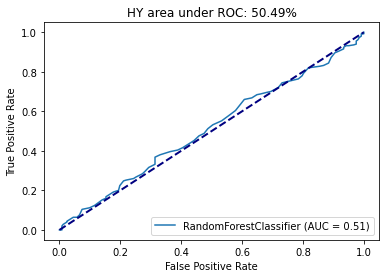

In [85]:
model_results[1]['CDX_HY_UpNext_1Day']['ROCplot']

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.9044715447154471
492
{0: 291, 1: 201}


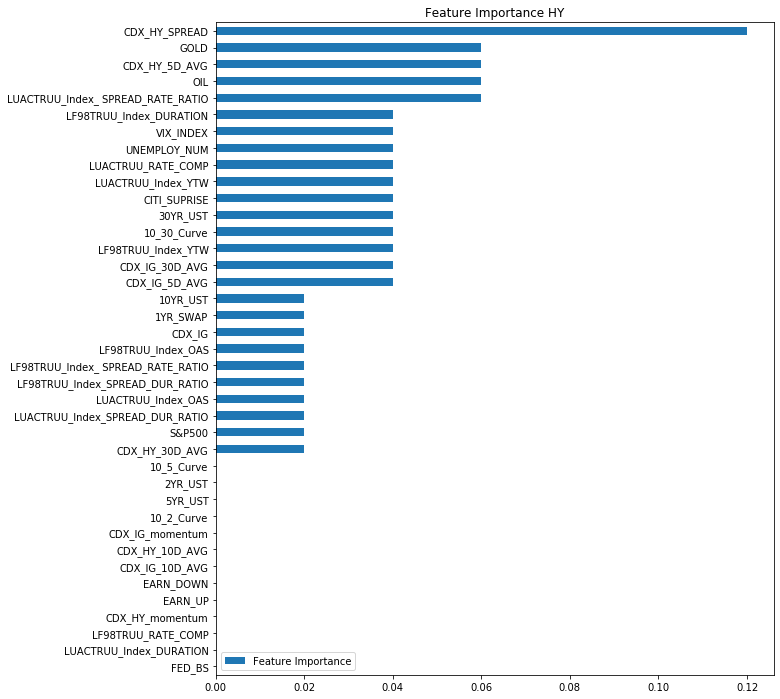

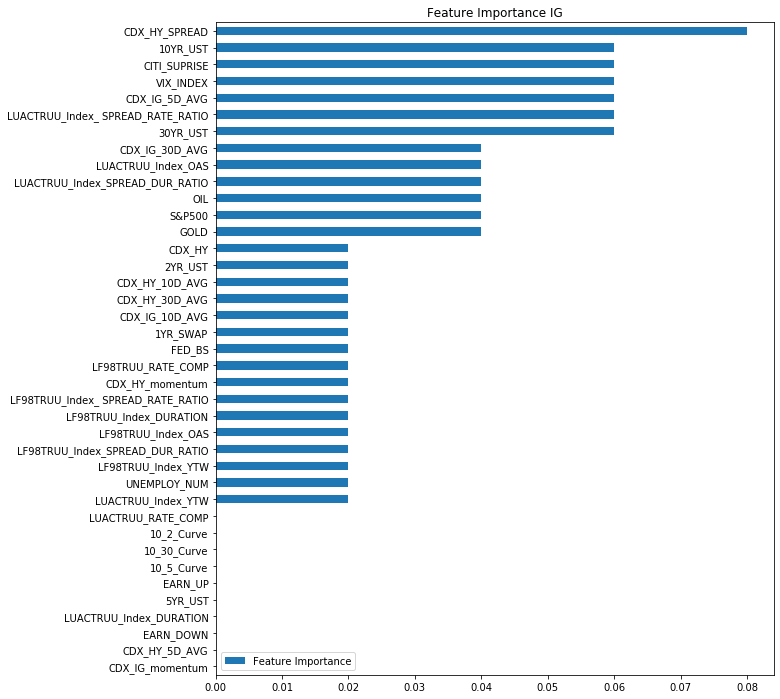

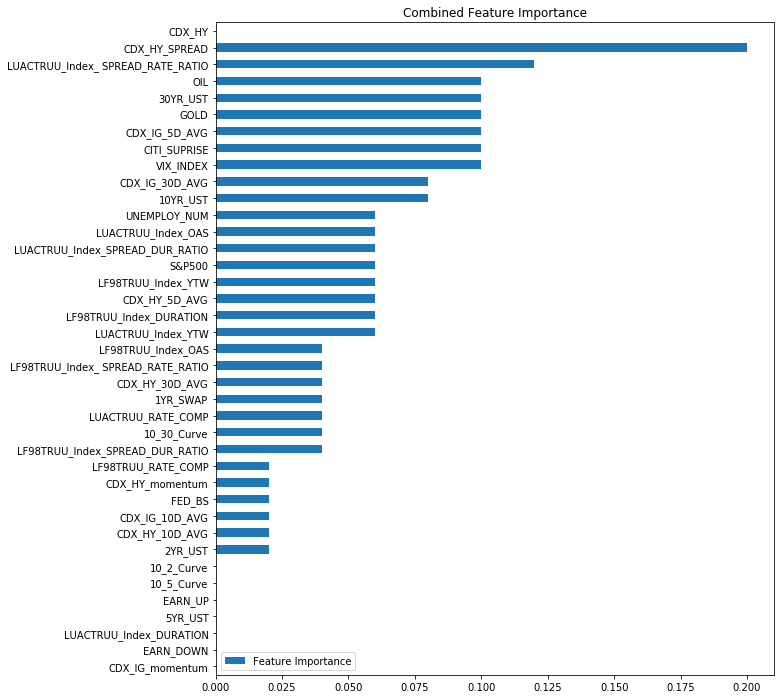

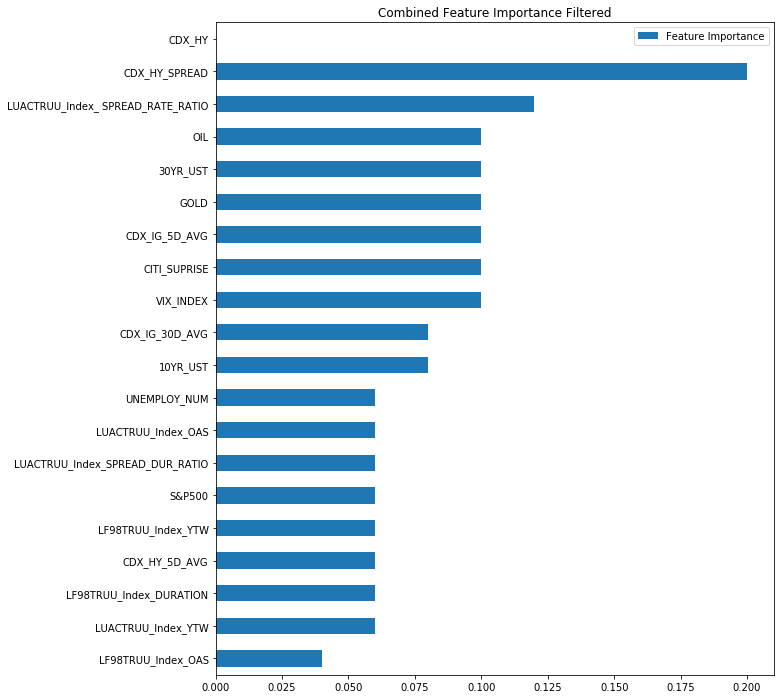

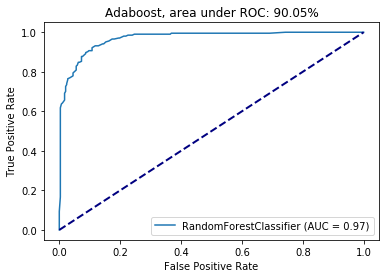

In [23]:
total_prediction(30)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.7967479674796748
492
{0: 280, 1: 212}


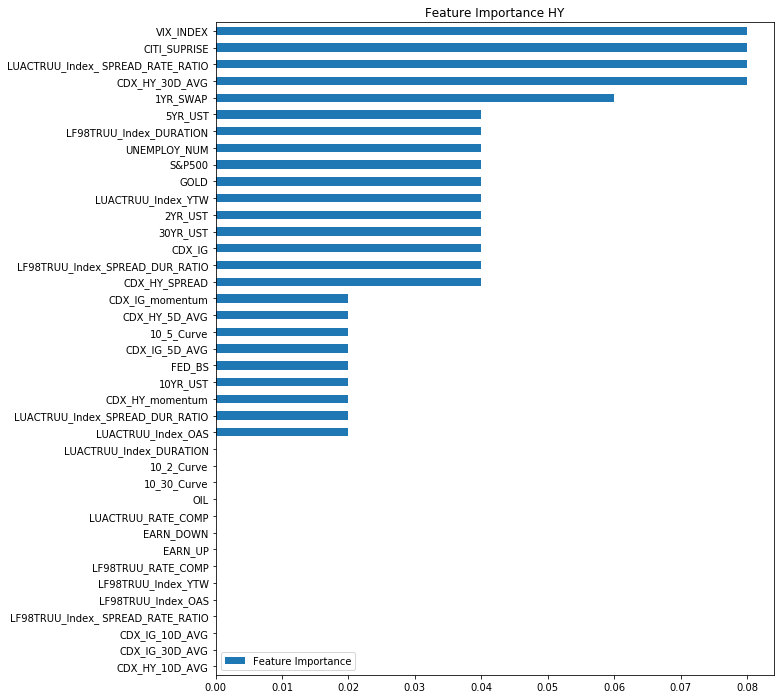

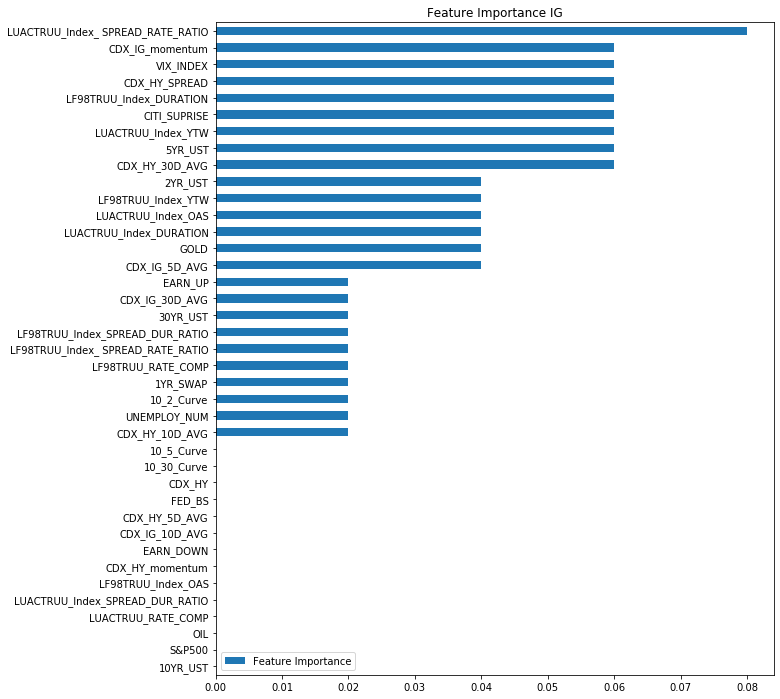

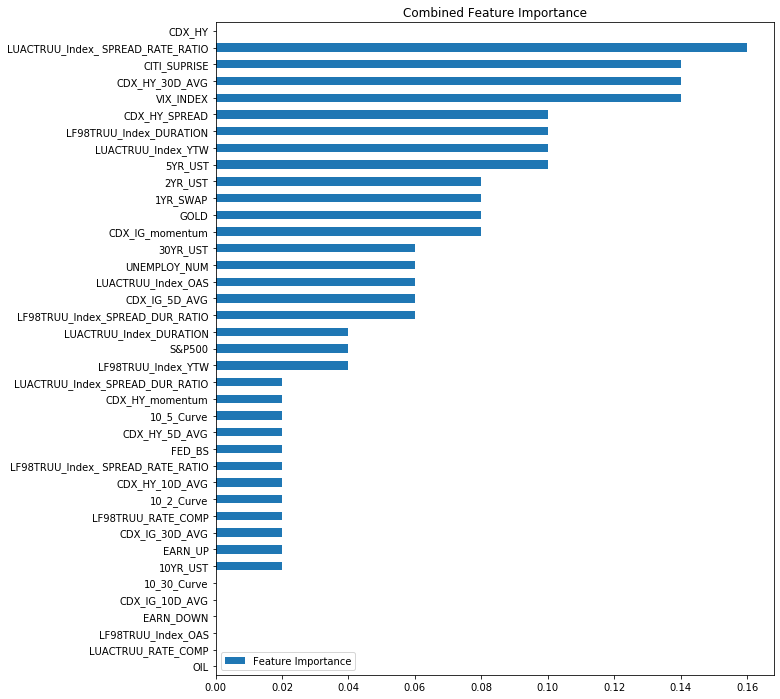

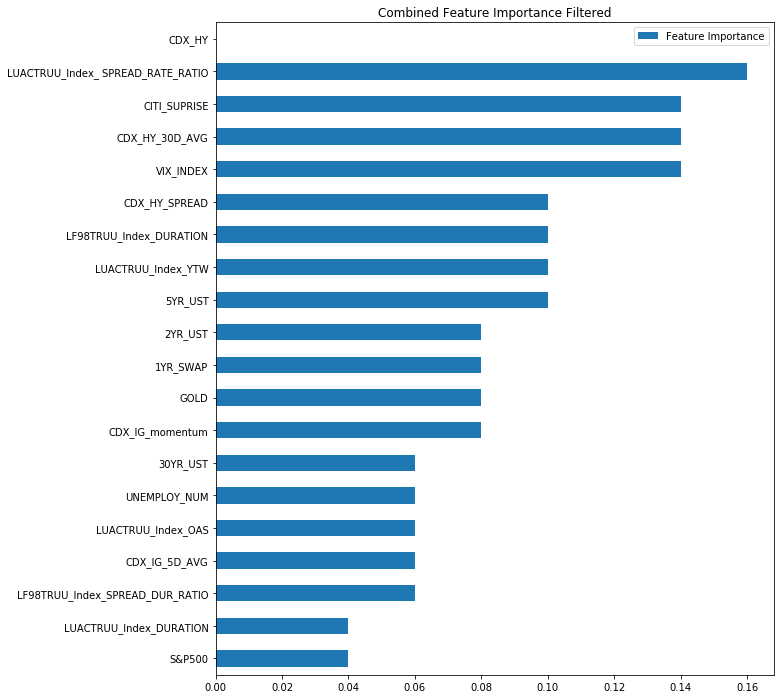

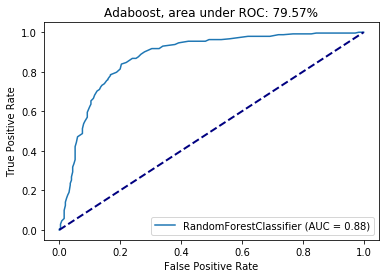

In [24]:
total_prediction(5)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.6626016260162602
492
{0: 277, 1: 215}


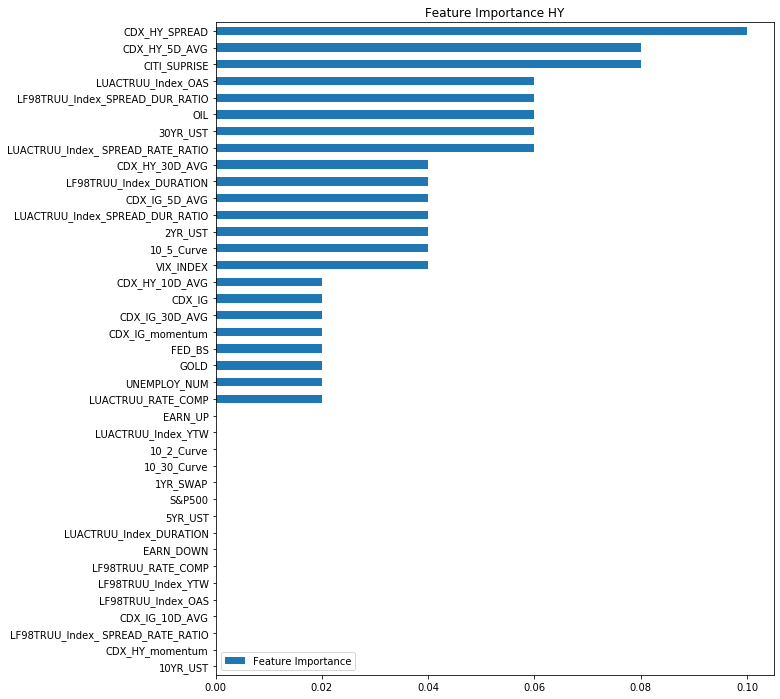

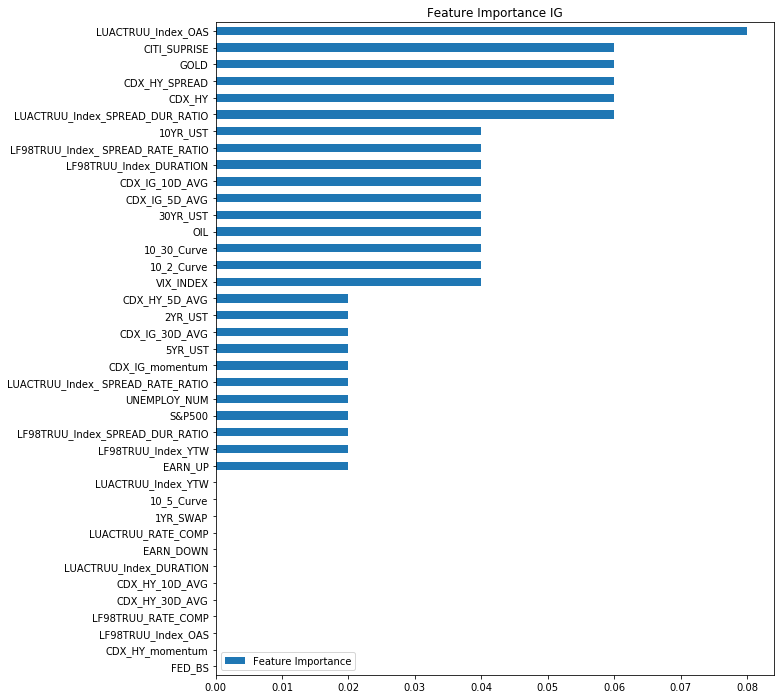

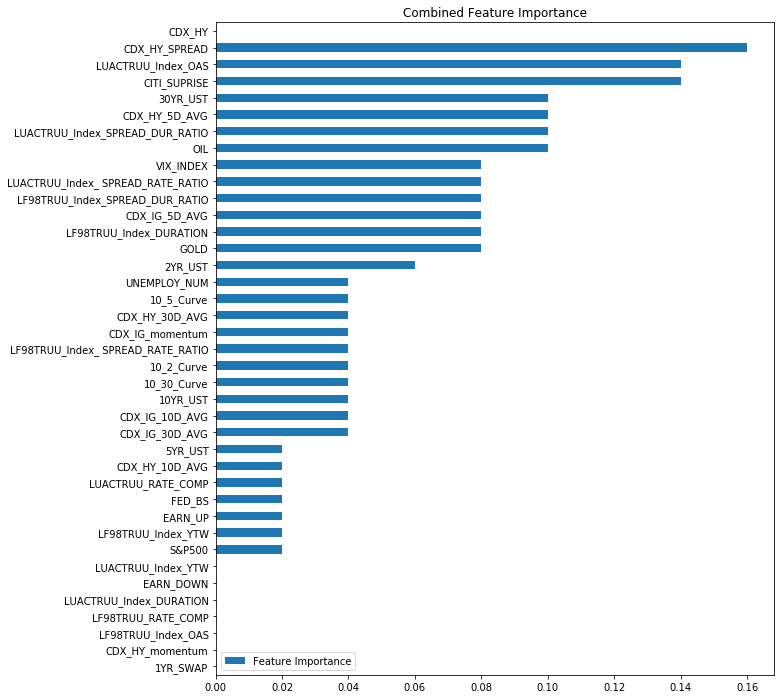

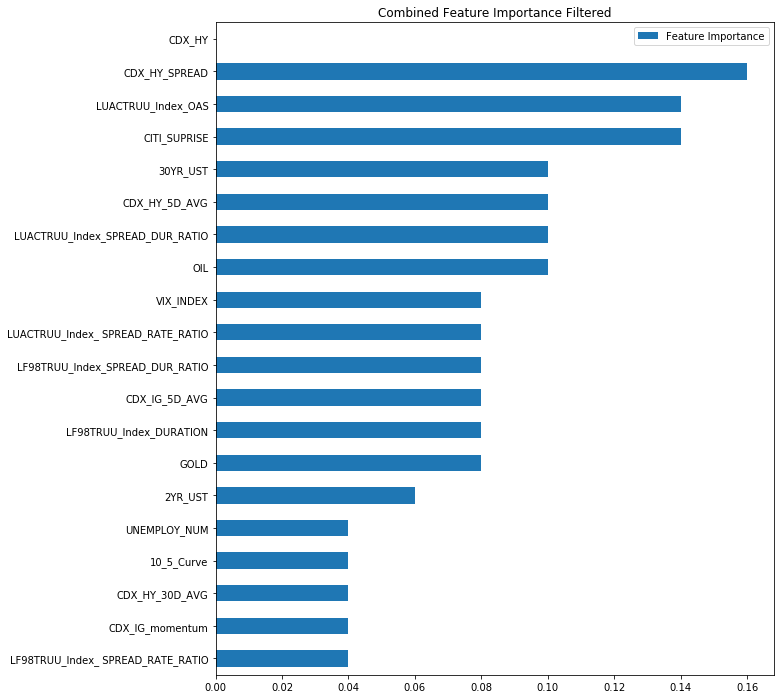

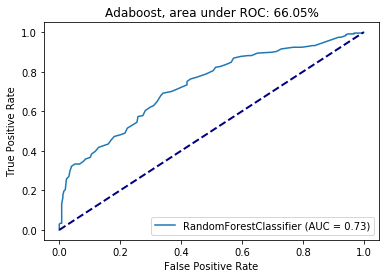

In [25]:
total_prediction(2)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.7317073170731707
492
{0: 293, 1: 199}


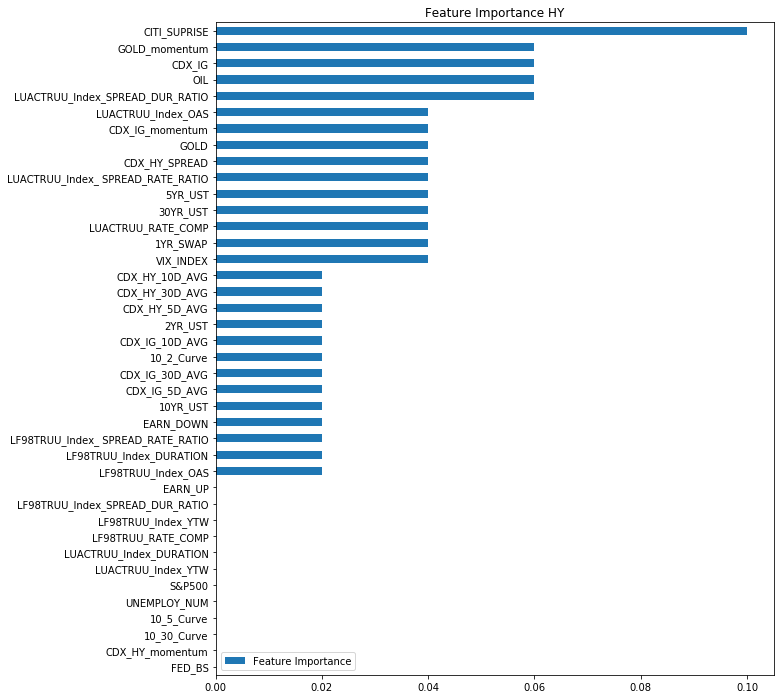

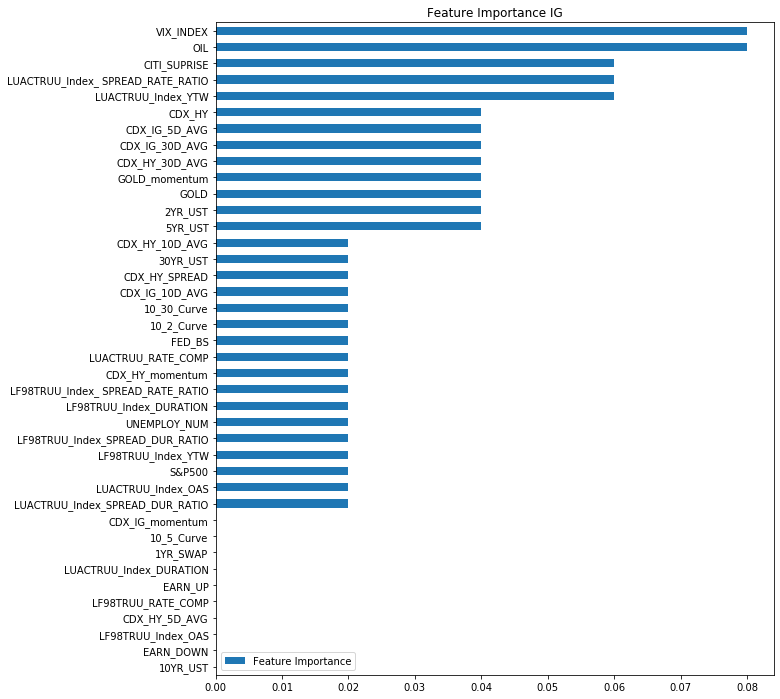

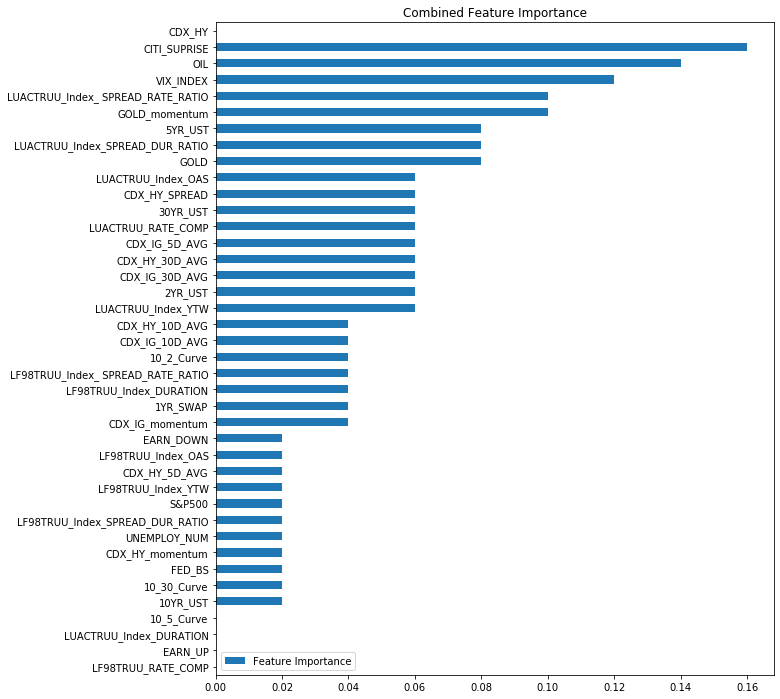

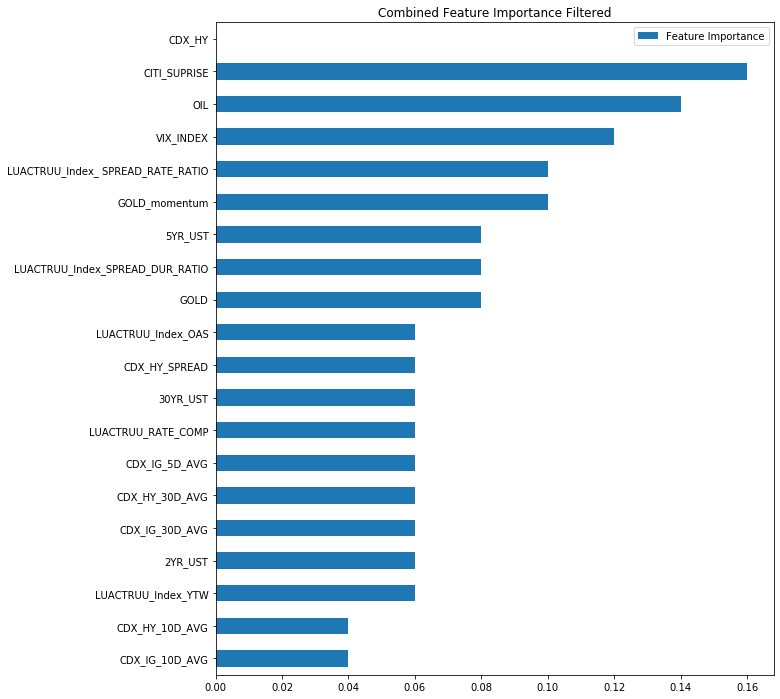

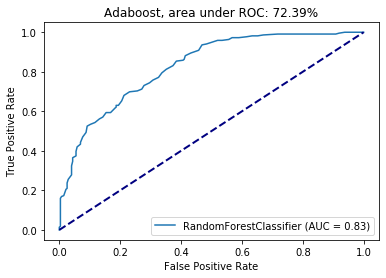

In [7]:
total_prediction(3)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.8821138211382114
492
{0: 275, 1: 217}


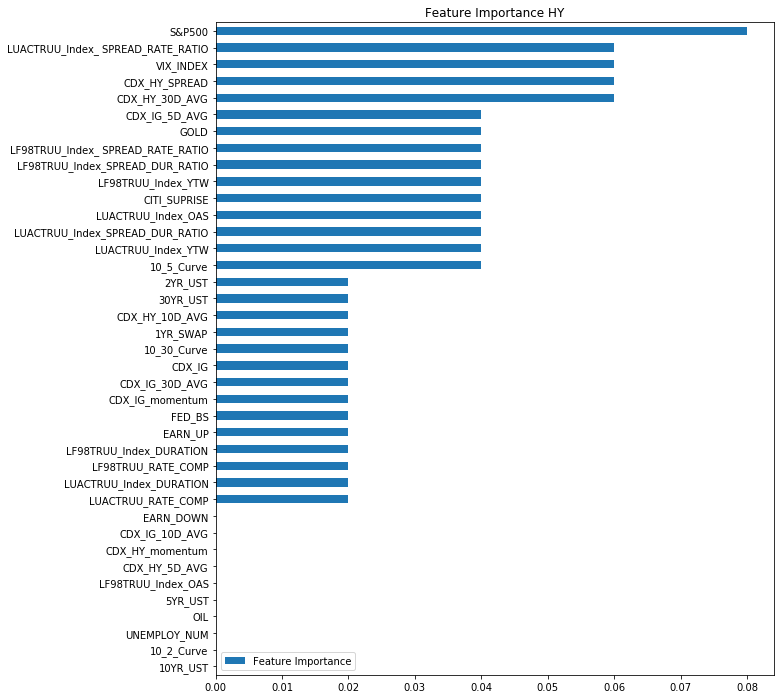

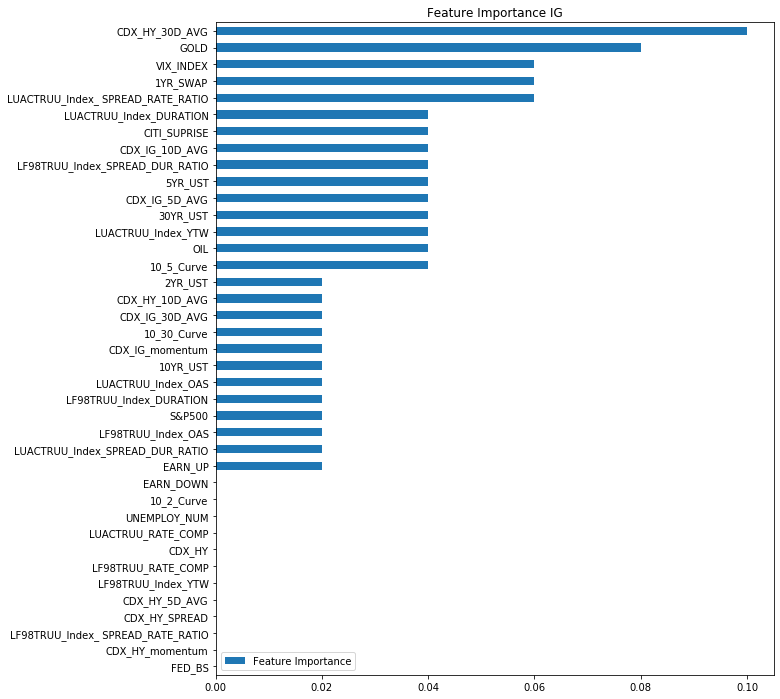

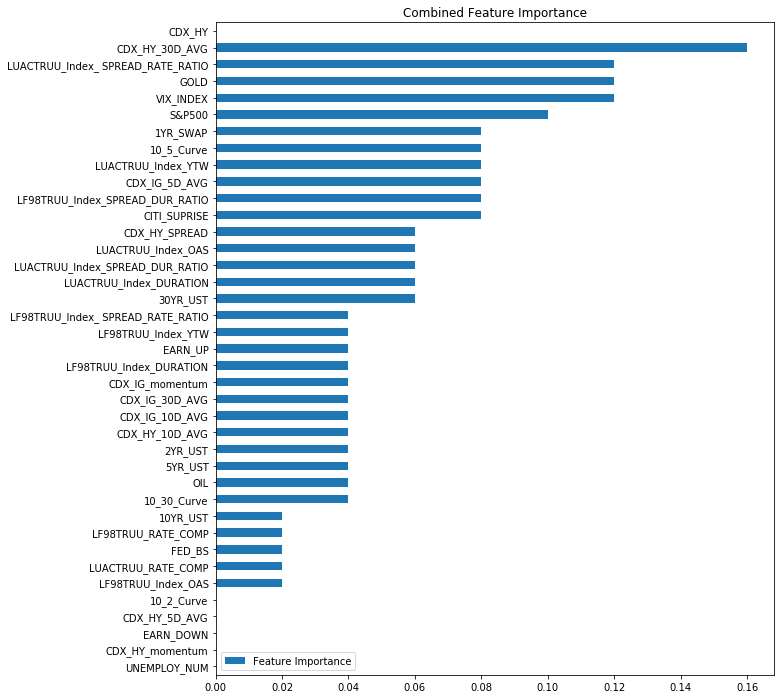

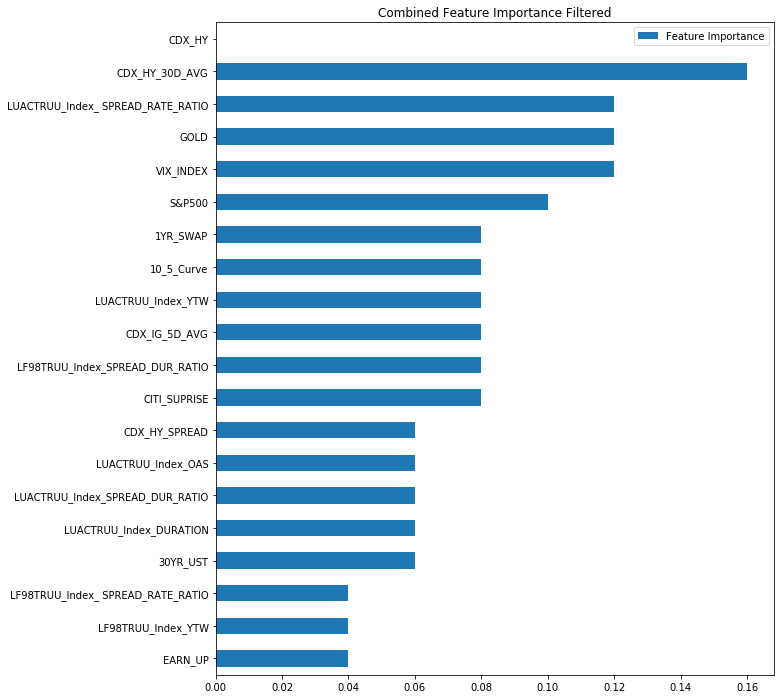

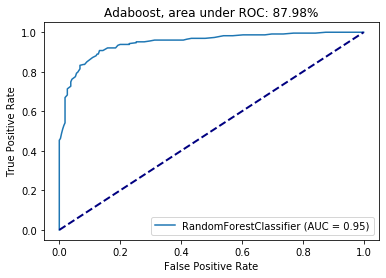

In [27]:
total_prediction(10)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.8536585365853658
492
{0: 273, 1: 219}


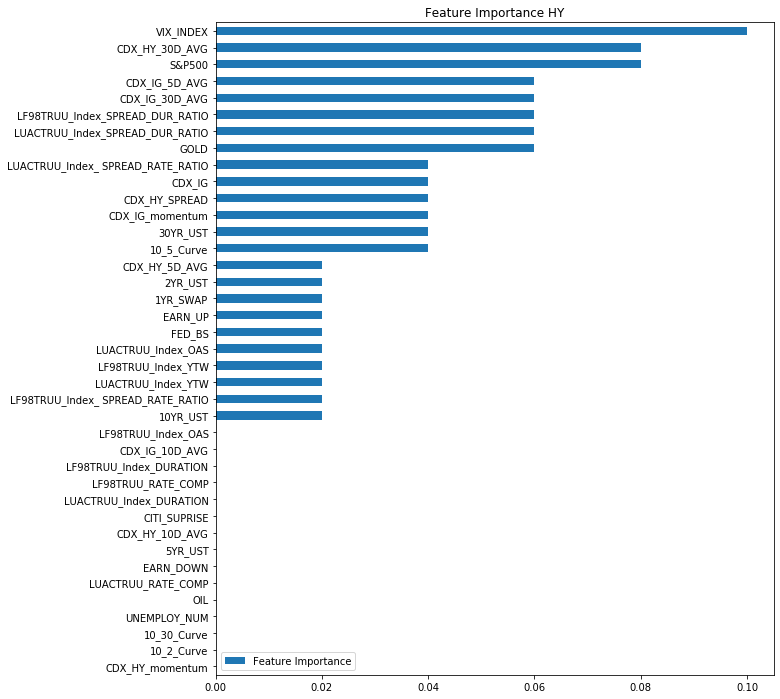

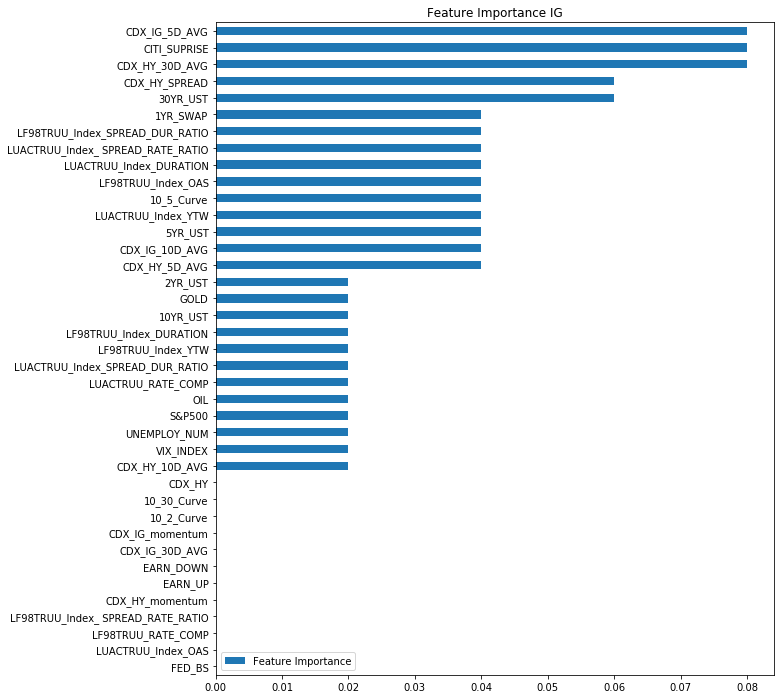

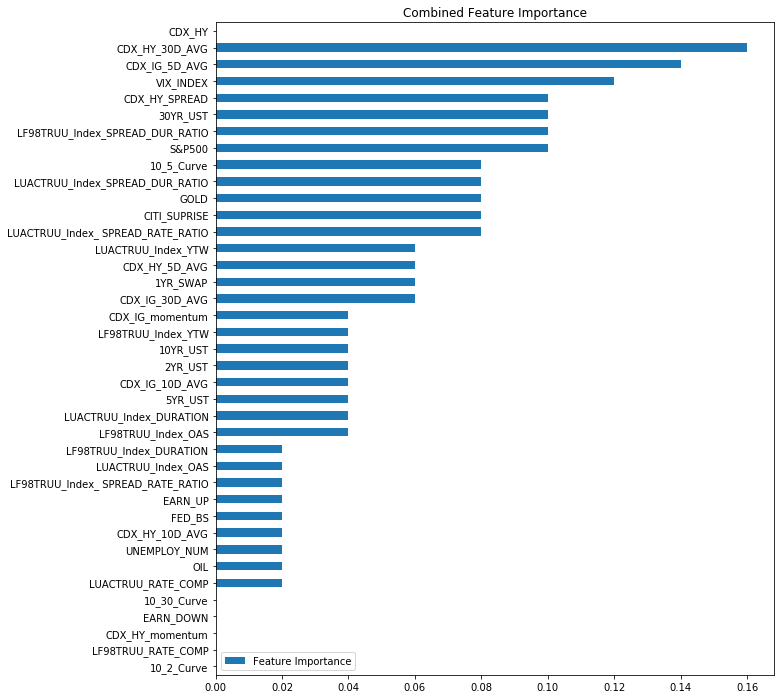

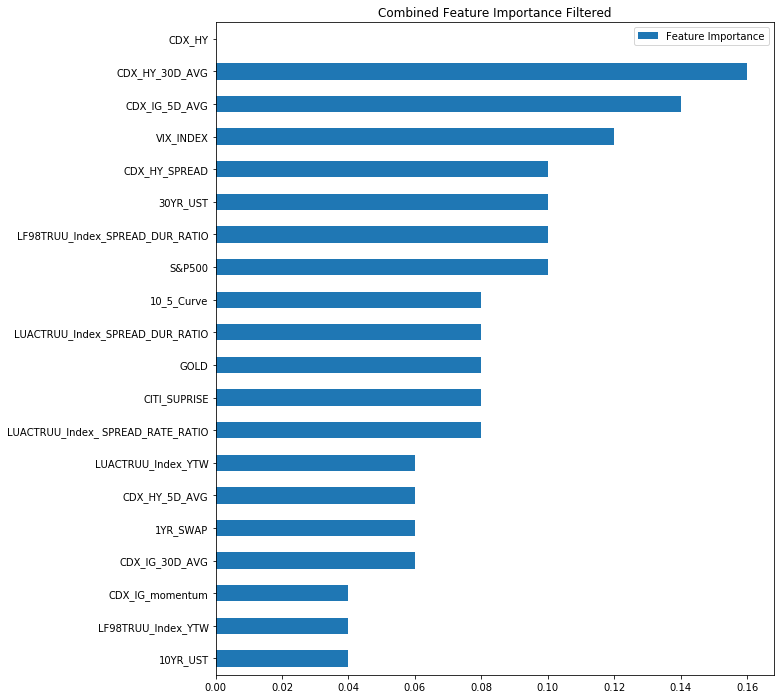

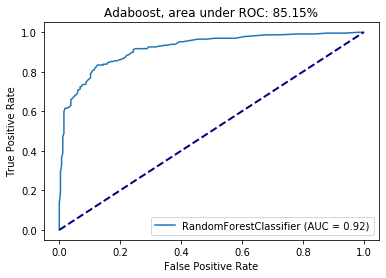

In [28]:
total_prediction(15)

Preprocessing data...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 29 to 1994
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   10YR_UST                           1966 non-null   float64
 1   10_2_Curve                         1966 non-null   float64
 2   10_30_Curve                        1966 non-null   float64
 3   10_5_Curve                         1966 non-null   float64
 4   1YR_SWAP                           1966 non-null   float64
 5   2YR_UST                            1966 non-null   float64
 6   30YR_UST                           1966 non-null   float64
 7   5YR_UST                            1966 non-null   float64
 8   CDX_HY                             1966 non-null   float64
 9   CDX_HY_10D_AVG                     1966 non-null   float64
 10  CDX_HY_30D_AVG                     1966 non-null   float64
 11  CDX_HY_5D_AVG                    

Fitting HY Random Forrest Model...
[0 1]
Accuracy 0.9004065040650406
492
{0: 280, 1: 212}


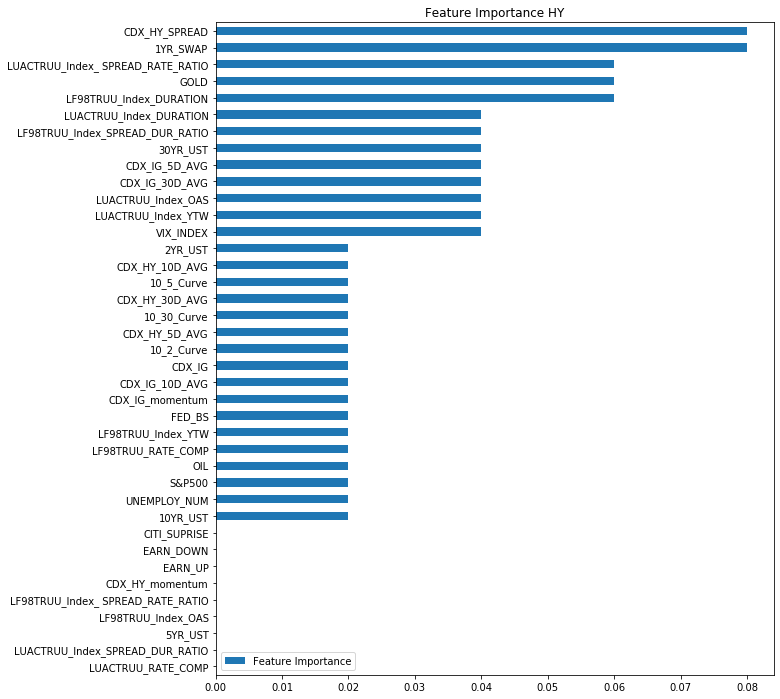

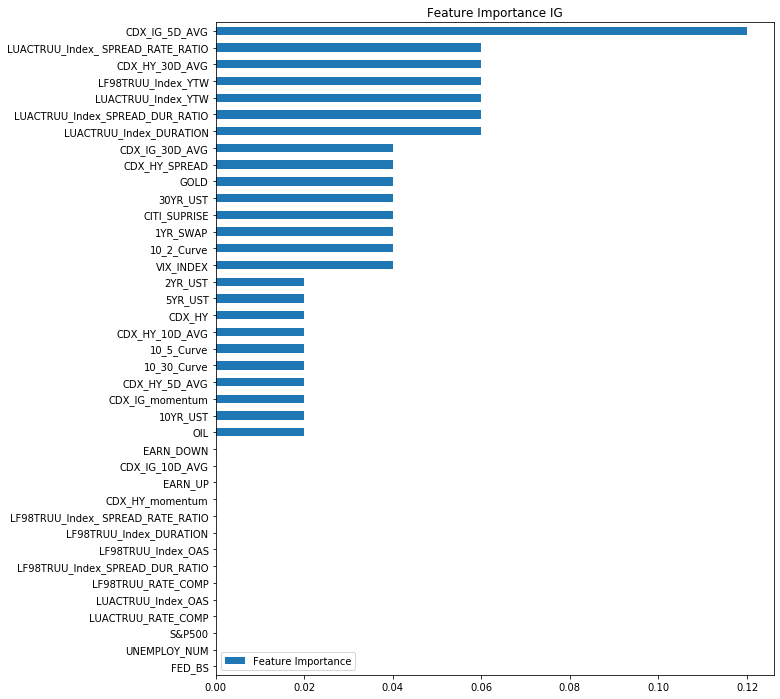

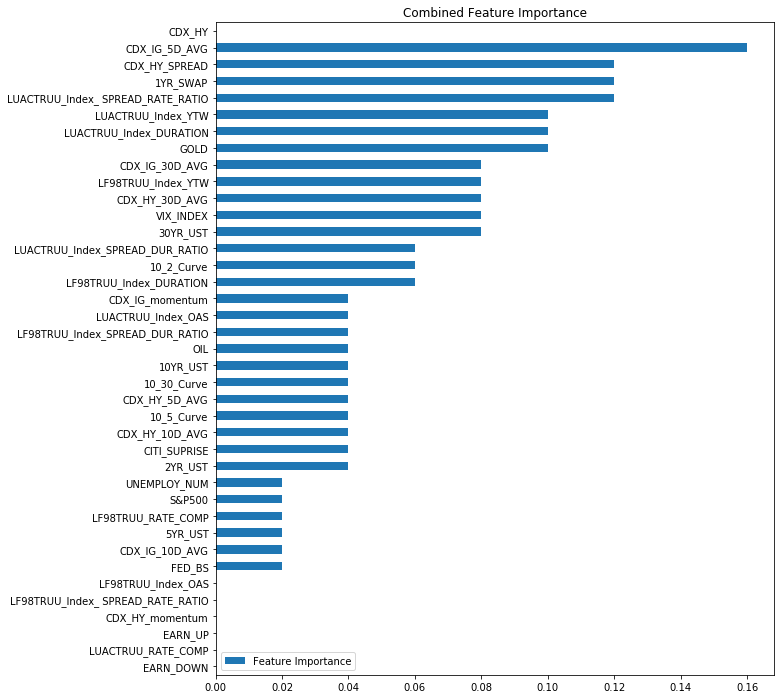

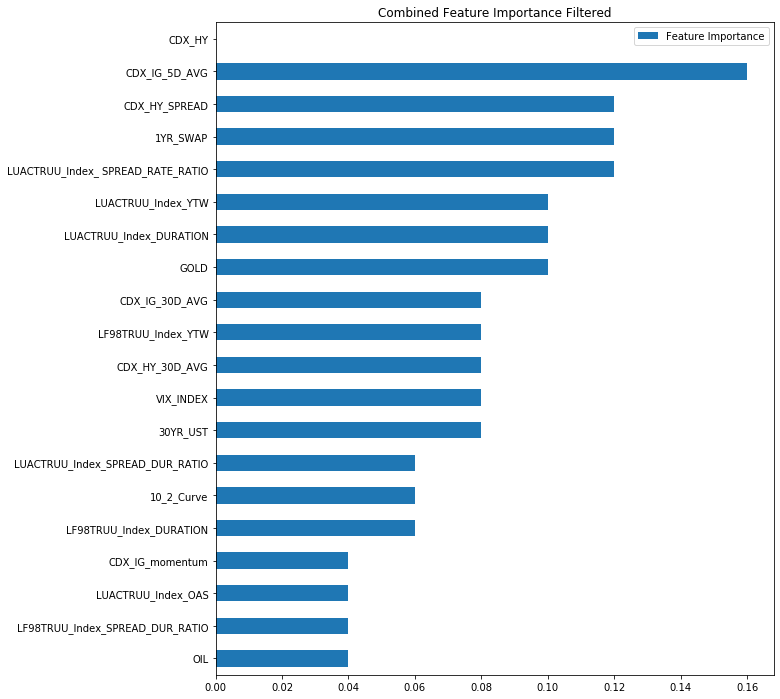

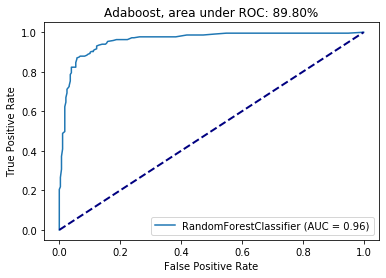

In [29]:
total_prediction(20)